# CS 422 Project

## Abstract

This project focused on developing a machine learning pipeline to classify a multi-class dataset, addressing challenges such as feature correlation and class imbalance. We implemented a scikit-learn-based pipeline that included standardization, Principal Component Analysis (PCA) for dimensionality reduction, and a Decision Tree classifier. The pipeline was successfully converted into an ONNX model for deployment, with both versions yielding an overall accuracy of 72%. The model demonstrated strong performance in identifying instances of Class 2, but struggled to differentiate between Classes 1 and 3, resulting in misclassifications. These findings indicate the need for further refinement, particularly in enhancing the model's ability to distinguish between similar classes. Future steps include exploring advanced feature engineering, addressing class imbalance, and experimenting with alternative algorithms to improve classification accuracy and robustness.

## Overview

<br>

The primary challenge addressed in this project is the development of a robust classification model using a very large dataset with significant class imbalance. The objective is to accurately predict the class labels, which are crucial for downstream applications such as predictive maintenance, anomaly detection, or quality control. To address the class imbalance and build an effective classification model, there are several key steps involved. First, the dataset will undergo preprocessing to handle missing values and normalize features. Next, exploratory data analysis will be performed to understand the data distribution and identify any potential issues. Given the high correlation between many features, dimensionality reduction techniques, such as Principal Component Analysis (PCA), will be considered to reduce multicollinearity. For model training, a Scikit-Learn based pipeline will be developed, incorporating techniques to address class imbalance, such as oversampling the minority class or adjusting class weights. Finally, the trained model will be converted to ONNX format for deployment, ensuring it can be efficiently used in production environments. Model performance will be evaluated using metrics that are sensitive to class imbalance, including precision, recall, and the F1-score, to ensure robust and unbiased predictions.

## Data Processing and Analysis

<br>

To prepare the data for training and testing, I first printed out basic statistics regarding the dataset. Since there was no missing values, there was no need to impute data. Then I made a heatmap of the correlation matrix and discovered one issue. There were significant features that had a high correlation. Features with high correlation suggest that they share similar patterns or information. In addition, correlations between the features and Class are generally weak. The high positive correlations between many features suggests that there is redundancy. Having highly correlated features may not provide additional information and could lead to multicollinearity issues. Features with high correlations to the target variable are potentially more informative for predictive modeling. However, due to the low correlations, no single feature stands out as highly predictive on its own. In order to address this issue, I used principal component analysis. PCA transforms the features into a set of linearly uncorrelated components while retaining most of the variability in the data. First I standardized the data using StandardScalar() and then performed PCA. 

<br>

Adding all the libraries that would be used for this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import onnxruntime as rt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

Next, I loaded the explored the dataset by outputting basic information and some statistics.

In [2]:
#load the dataset
data = pd.read_csv('data_public.csv')

#display basic information about the dataset
print("Basic information about the dataset:")
print(data.info())

#display first few rows of the dataset
print("\nFirst five rows of the dataset:")
print(data.head())

#display summary statistics
print("\nSummary statistics of the dataset:")
print(data.describe())

#check for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 146.5 MB
None

First five rows of the dataset:
            A          B           C          D          

Here we have some basic information about the dataset. We can also observe that there are no missing values, therefore, we will not need to use methods to impute data. Next, I decided to visualize the data. I visualized the correlation matrix to understand the relationship between different features using a heatmap.

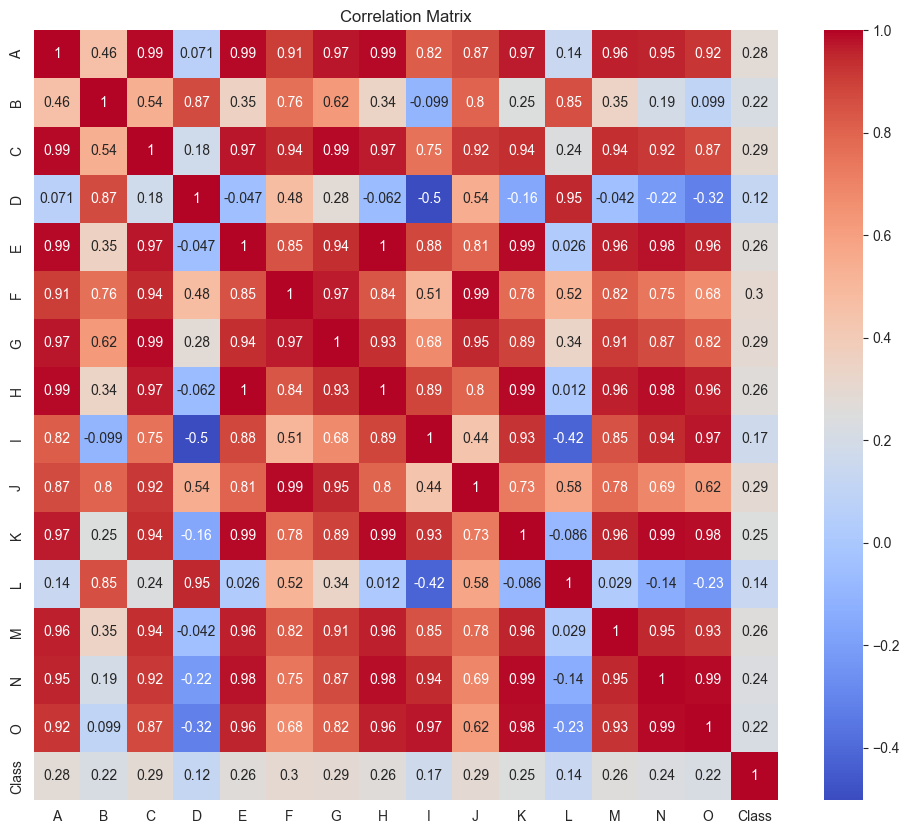

In [3]:
#visualize correlation matrix
plt.figure(figsize=(12,10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Next we standardized the features and then performed PCA to address the issue that was highlighted in the heatmap.

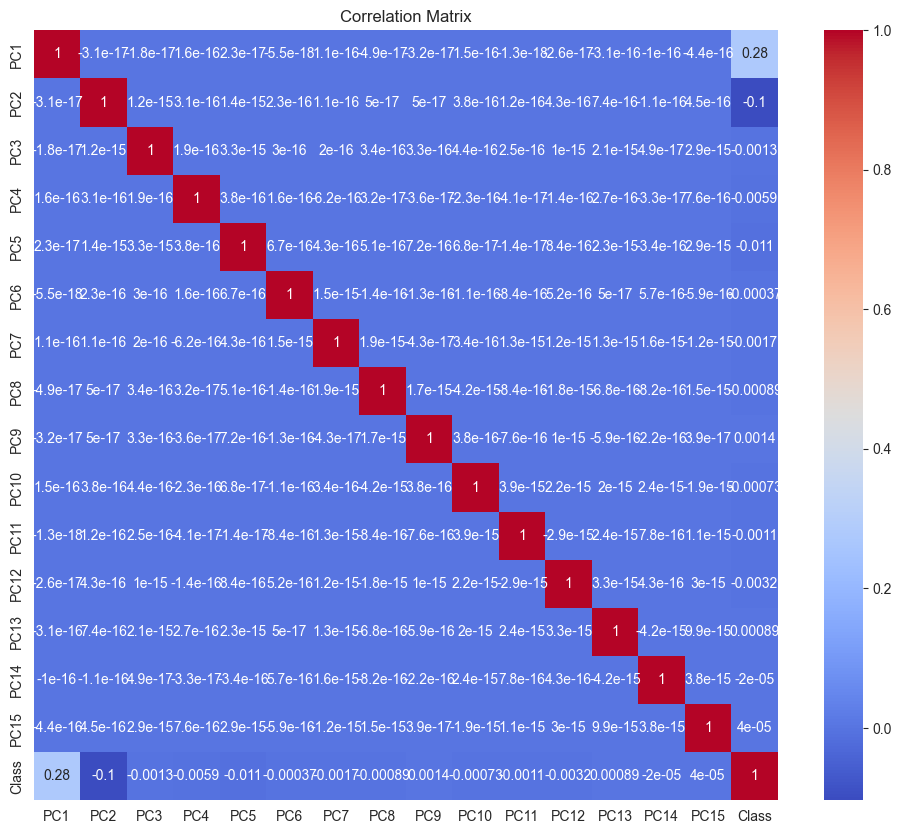

In [3]:
#separate features and target
X = data.drop('Class', axis=1)
y = data['Class']

#standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#create a new dataframe with the principal components
dataframe_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
dataframe_pca['Class'] = y.reset_index(drop=True)

#visualize correlation matrix
plt.figure(figsize=(12,10))
correlation_matrix = dataframe_pca.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Observing the heatmap, we can now see that there is low correlation between each feature. 

## Model Training

<br>

Now we prepare our data for testing and training. With the PCA transformed data, I split the data into training and testing sets. 80% of the data will be used to train the model while the rest of the 20% will be used to test and evaluate the performance of the model. To achieve this, I used train_test_split() from sklearn. I set test_size equal to 0.2 to set the 80-20 split.  The final thing I did before training and testing was output summary stats and visualize the data. 

In [4]:
#split the PCA transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

#display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (960000, 15)
Shape of X_test: (240000, 15)
Shape of y_train: (960000,)
Shape of y_test: (240000,)


Statistics of our dataset 

Summary Statistics:
                PC1           PC2           PC3           PC4           PC5   
count  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06  \
mean  -8.526513e-18 -1.188975e-17 -1.100009e-17 -3.465672e-17  3.118987e-18   
std    3.317828e+00  1.932733e+00  2.986904e-01  2.472967e-01  2.280081e-01   
min   -3.470056e+00 -2.309421e+00 -1.802816e+00 -1.515646e+00 -1.347924e+00   
25%   -2.226447e+00 -1.458926e+00 -1.935611e-01 -1.218922e-01 -1.504208e-01   
50%   -2.133110e+00 -5.166472e-01  3.274149e-05  2.280747e-03 -3.054107e-03   
75%    4.577040e+00  3.536480e-01  1.936501e-01  1.243903e-01  1.463717e-01   
max    5.345375e+00  5.167835e+00  1.841666e+00  1.552262e+00  1.392280e+00   

                PC6           PC7           PC8           PC9          PC10   
count  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06  \
mean   3.865056e-18  4.545993e-17 -3.801478e-17 -2.305360e-17 -3.535764e-17   
std    9.933319e-02  9.180188e-

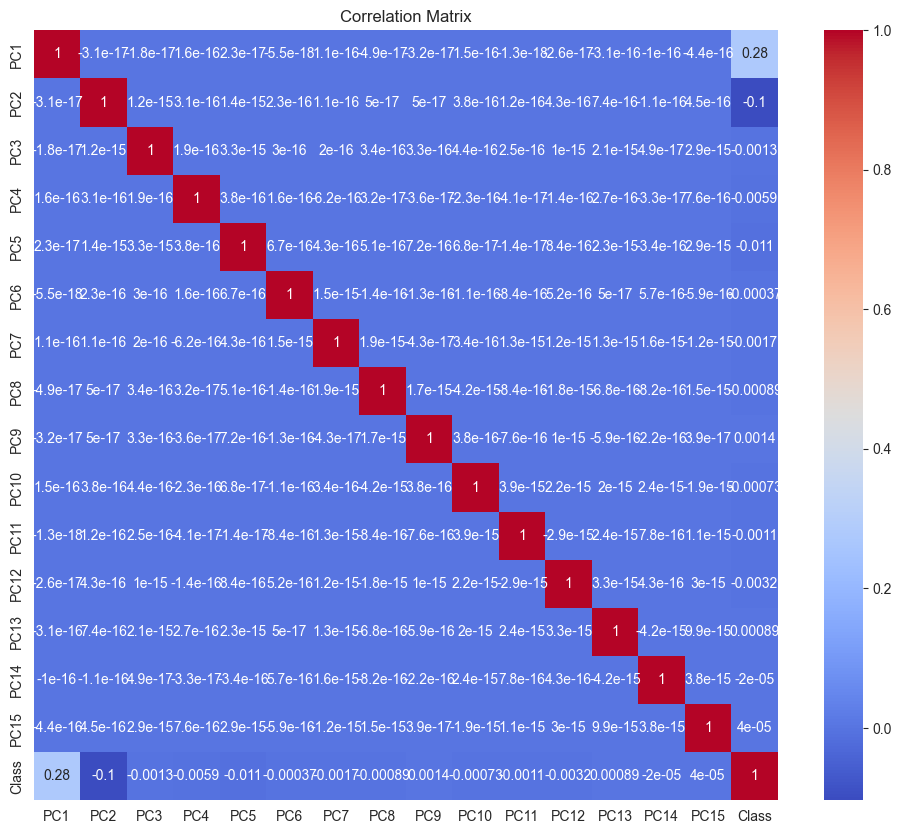

In [7]:
#summary stats
print("Summary Statistics:")
print(dataframe_pca.describe())

#------ visualization ------

#correlation matrix
corr_matrix = dataframe_pca.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

To make the pipeline, I first divided the data into two groups: X and y. X will have all features except for Class. y will have Class. I separated that data into two main groups. The first group is data that will be used to train the model. The second group is data that will be used to test the model. 80% of the data will be used to train the data, and 20% will be used to test it. In the pipeline, I will scale the data using StandardScaler(). To address the issue with the highly correlated features, PCA() will be used. Finally, RandomForestClassifier() will be used in the pipeline. 

<br>

When making the pipeline, I encountered one problem. I made the pipeline without making any adjustments to PCA() or RandomForestClassifier(). The code never finished running, therefore I assume it would have taken a very long time for it to finish running. I obviously had to make some adjustments. The first adjustment I made was to give n_components a value of 10 in the PCA() function. This reduced the dimensionality of the dataset down to 10 features. In the RandomForestClassifier() function, n_estimators was set to 100 in order to only use 100 trees. max_depth was set to 10 in order to limit the depth of the trees. n_jobs was set to -1, which allows the use of all CPU cores for parallel processing. By modifying the code like this, the runtime of the code significantly decreased. 

In [7]:
data = pd.read_csv('data_public.csv')

X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)),
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.41      0.45     36189
           2       0.75      1.00      0.86     89845
           3       0.76      0.61      0.68    113966

    accuracy                           0.72    240000
   macro avg       0.67      0.67      0.66    240000
weighted avg       0.72      0.72      0.71    240000



In [8]:
y_pred

array([1, 1, 3, ..., 3, 3, 3], dtype=int64)

In [6]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[14907     0 21282]
 [    0 89844     1]
 [14639 30139 69188]]


First, I displayed the results of the classification_report() function with y_test and y_pred as inputs. This function provides several metrics for evaluation like precision, recall, F1 score, support, and accuracy. I also displayed the output of y_pred. y_pred will make a prediction on the test data using our trained machine learning pipeline in scikit learn. Finally, I generated a confusion matrix using y_test and y_pred as inputs. The first input, y_test, is the array of containing the actual labels for the test data. These are the values the model is trying to predict. The second input, y_pred, is the array of containing the predicted labels generated by the model. These are the labels that the model has predicted based on the input from the test data. A confusion matrix will be generated with these two inputs to evaluate the accuracy of classification model by comparing the actual labels to the predicted labels.  

## Model Validation

Something else I wanted to test was to make another pipeline, but with DecisionTreeClassifier() rather than RandomForestClassifier(). I decided to set a binary Decision Tree with a minimum of 2 instances in the leaves, no splits of subsets below 5, a maximal tree depth of 2, and set criterion to 'gini'. This pipeline resulting in slightly better score for classification reports. Accuracy remained about the same. The biggest improvement was the execution time. When I used RandomForestClassifier(), the program would finish running in about one and a half minutes. When using DecisionTreeClassifier(), the program would finish running in about ten seconds.  

In [9]:
dt_classifier = DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=5, max_depth=2, criterion='gini')
pipeline_dtc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', dt_classifier),
])

pipeline_dtc.fit(X_train, y_train)
y_pred_dtc = pipeline_dtc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dtc))
print("Classification Report:\n", classification_report(y_test, y_pred_dtc))

Accuracy: 0.7240958333333334
Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.56      0.53     36189
           2       0.75      1.00      0.86     89845
           3       0.80      0.56      0.66    113966

    accuracy                           0.72    240000
   macro avg       0.68      0.71      0.68    240000
weighted avg       0.74      0.72      0.71    240000



In [10]:
pipeline_dtc.predict(X_test)

array([1, 1, 3, ..., 1, 1, 3], dtype=int64)

In [11]:
dtc_conf_matrix = confusion_matrix(y_test, y_pred_dtc)
print("Confusion Matrix:\n", dtc_conf_matrix)

Confusion Matrix:
 [[20086     0 16103]
 [    0 89842     3]
 [19972 30139 63855]]


To create an ONNX model for testing, we will first need to convert the trained scikit-learn pipeline into an ONNX format using the 'skl2onnx' library. Then, we can test the ONNX model using the onnxruntime library to ensure it produces the same results as the original scikit-learn pipeline. Like the sklearn pipeline, we can also obtain metrics regarding the ONNX model. Like the pipeline, we will obatin the accuracy, classification report, and confusion matrix.

In [12]:
input_types = [('float_input',FloatTensorType([None, X_train.shape[1]]))]

try:
    model_onnx = convert_sklearn(pipeline_dtc, 'pipeline_project_onnx', initial_types=input_types)
except Exception as e:  
    print(e)

with open("project_pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [13]:
session = rt.InferenceSession("project_pipeline.onnx")

input_name = session.get_inputs()[0].name
label_name = session.get_outputs()[0].name
X_test_onnx = X_test.values.astype(np.float32)

y_pred_onnx = session.run([label_name], {input_name: X_test_onnx})[0]

print("ONNX Model Classification Report:\n", classification_report(y_test, y_pred_onnx))

ONNX Model Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.56      0.53     36189
           2       0.75      1.00      0.86     89845
           3       0.80      0.56      0.66    113966

    accuracy                           0.72    240000
   macro avg       0.68      0.71      0.68    240000
weighted avg       0.74      0.72      0.71    240000



In [14]:
onnx_conf_matrix = confusion_matrix(y_test, y_pred_onnx)
print("Confusion Matrix:\n", onnx_conf_matrix)

Confusion Matrix:
 [[20086     0 16103]
 [    0 89842     3]
 [19972 30139 63855]]


As we can observe, the ONNX model displays the same results as the sklearn pipeline. This means that the ONNX model is functioning correctly and has been successfully converted from the scikit-learn pipeline without any loss of information or functionality.  

<br>

Now it's time to analyze the actual results of our metrics. The precision for Class 1 is 0.50, meaning that when the model predicts Class 1, it is correct 50% of the time. The precision for Class 2 is 0.75, indicating a higher confidence in correctly identifying Class 2. The precision for Class 3 is 0.80, which is the highest among the classes, suggesting that predictions for Class 3 are mostly correct. The recall for Class 1 is 0.56, meaning that out of all the actual instances of Class 1, the model correctly identifies 56% of them. The recall for Class 2 is very high at 1.00, indicating that the model correctly identifies nearly all instances of Class 2. The recall for Class 3 is 0.56, similar to Class 1, meaning that the model correctly identifies 56% of actual Class 3 instances. The F1-score for Class 1 is 0.53, balancing precision and recall. The F1-score for Class 2 is 0.86, indicating a strong performance. The F1-score for Class 3 is 0.66, lower than Class 2 but still decent. The model's accuracy is 0.72, meaning it correctly classifies 72% of the instances across all classes.

<br>

Next, we analyze the confusion matrix. Class 1 (row 1) has 20086 correctly predicted instances and 16103 incorrectly predicted instances. The model struggles with correctly identifying Class 1, as indicated by the high number of false negatives (predicted as Class 3). Class 2 (row 2) has 89842 correctly predicted instances and only 3 incorrectly predicted instances. This indicates that this model is very good being able to correctly classify Class 2. Class 3 (row 3) has 63855 correctly predicted instances and 19972 incorrectly predicted instances as Class 1 and 30139 incorrectly predicted instances as Class 2. The model has difficulty distinguishing Class 3 from Classes 1 and 2, leading to a significant number of misclassifications.

<br>

Class 2 is much more accurately identified compared to Classes 1 and 3. This could be due to an imbalance in the data, where Class 2 has more instances or distinct features that make it easier to classify. There is significant confusion between Classes 1 and 3. The model often misclassifies instances of Class 1 as Class 3 and vice versa. This suggests that the features distinguishing these two classes are not as clear, and the model has difficulty separating them. The model is very strong in identifying Class 2, with nearly perfect recall and a high F1-score, which indicates that it is very good at detecting instances of this class. The model could be improved by focusing on better distinguishing between Classes 1 and 3. To improve the model, it might involve additional feature engineering, more sophisticated modeling techniques, or addressing class imbalance.

<br>

Overall, the model performs well with an accuracy of 72%, but there is room for improvement, particularly in reducing the misclassification between Classes 1 and 3. Class 2 is very well-identified, which suggests that the model has learned to recognize this class effectively. To enhance the model's performance, especially for Classes 1 and 3, further exploration and potentially more advanced techniques may be required.

## Conclusion

In this project, we successfully developed and validated a machine learning pipeline using a scikit-learn-based approach, which was later converted to an ONNX model for deployment. The model achieved an overall accuracy of 72%, with strong performance in identifying instances of Class 2, as evidenced by high precision, recall, and F1-score. However, the model exhibited notable challenges in distinguishing between Classes 1 and 3, leading to a significant number of misclassifications. While the ONNX model faithfully replicated the scikit-learn pipeline's performance, indicating a successful conversion, the results suggest that further refinement is needed. A recommendation would be exploring advanced techniques, such as additional feature engineering, addressing potential class imbalance, or trying more sophisticated algorithms to improve the model's ability to differentiate between similar classes. It is important to approach these results with caution, as the observed class imbalance and feature overlap might lead to biased predictions in specific scenarios, particularly in real-world applications where model accuracy is critical.


## Data Sources

The dataset used in this project consists of multi-class classification data with 16 features and one target variable ('Class'). The data was generated and provided just for this project.  

Before analysis, the dataset underwent preprocessing, including the removal of rows with missing values and standardization of features to ensure consistency in the model training process.


## Source Code

The source code for this project includes scripts and notebooks that handle data preprocessing, model training, evaluation, and the conversion of the scikit-learn pipeline to an ONNX model. The code was developed using Python 3.11 and relies on libraries such as scikit-learn, numpy, pandas, and skl2onnx.

<br>

https://www.python.org/

<br>

https://pandas.pydata.org/

<br>

https://numpy.org/

<br>

https://matplotlib.org/

<br>

https://seaborn.pydata.org/

<br>

https://onnxruntime.ai/

<br>

https://scikit-learn.org/stable/

<br>

https://pypi.org/project/skl2onnx/

## Bibliography

### Bibliography

**Academic Papers:**
   - He, H., & Garcia, E. A. (2009). Learning from Imbalanced Data. *IEEE Transactions on Knowledge and Data Engineering*, 21(9), 1263-1284. https://doi.org/10.1109/TKDE.2008.239
   - Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. *Journal of Artificial Intelligence Research*, 16, 321-357. https://doi.org/10.1613/jair.953
   - Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
   - Buitinck et al., 2013. 

<br>

**Software and Tools:**
   - “Python 3.11.8 Documentation.” 3.11.8 Documentation. Accessed July 31, 2024. https://docs.python.org/3.11/. 
   - “ONNX Runtime.” ONNX Runtime. Accessed July 31, 2024. https://onnxruntime.ai/docs/. 
   - “API Reference.” scikit-learn. Accessed July 31, 2024. https://scikit-learn.org/stable/api/index.html. 
   - “Pandas Documentation.” pandas documentation - pandas 2.2.2 documentation, April 10, 2024. https://pandas.pydata.org/docs/.
   - “NumPy Documentation.” NumPy documentation - NumPy v2.0 Manual. Accessed July 31, 2024. https://numpy.org/doc/stable/.